<a href="https://colab.research.google.com/github/aman06012003/hackathon/blob/main/BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bert Using Torch**

In [ ]:
!pip install -qq transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
from transformers import(
    BertModel,
    BertTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)
import torch
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import zipfile

In [ ]:
df = pd.read_csv("/content/Sentences_50Agree.txt",encoding = "ISO-8859-1",on_bad_lines='skip',sep = " .@")
df.tail(5)
df.columns = ['News_sentences','sentiment']

In [ ]:
df.head()

,News_sentences,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive


In [ ]:
df["sentiment"].value_counts()

neutral     2822
positive    1332
negative     592
Name: sentiment, dtype: int64

In [ ]:
df["sentiment"].isnull().sum()

99

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4845 entries, 0 to 4844
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   News_sentences  4845 non-null   object
 1   sentiment       4746 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


Text(0.5, 0, 'sentiment')

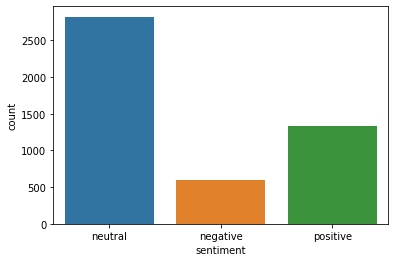

In [ ]:
sns.countplot(x="sentiment", data=df)
plt.xlabel("sentiment")

In [ ]:
# to transform string labels to integer values
LE = LabelEncoder()
df["sentiment_enc"] = LE.fit_transform(df["sentiment"].values)

In [ ]:
df.head(5)

,News_sentences,sentiment,sentiment_enc
0,Technopolis plans to develop in stages an area...,neutral,1
1,The international electronic industry company ...,negative,0
2,With the new production plant the company woul...,positive,2
3,According to the company 's updated strategy f...,positive,2
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive,2


In [ ]:
class_names = ["negative", "neutral", "positive"]

In [ ]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = "Sales of clothing developed best."

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f" Sentence: {sample_txt}")
print(f"   Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

 Sentence: Sales of clothing developed best.
   Tokens: ['Sales', 'of', 'clothing', 'developed', 'best', '.']
Token IDs: [15689, 1104, 5413, 1872, 1436, 119]


In [ ]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=12,
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt",  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding["input_ids"][0]))
encoding["input_ids"][0]

12


tensor([  101, 15689,  1104,  5413,  1872,  1436,   119,   102,     0,     0,
            0,     0])

In [ ]:
print(len(encoding["attention_mask"][0]))
encoding["attention_mask"]

12


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])

In [ ]:

tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])

['[CLS]',
 'Sales',
 'of',
 'clothing',
 'developed',
 'best',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
token_lens = []

for txt in df.News_sentences:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

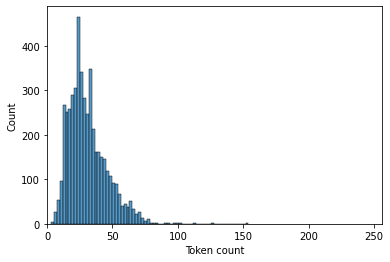

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 256])
plt.xlabel("Token count")

In [ ]:
max_len = 72

In [ ]:
class Sentiment_ana():
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "review_text": review,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "targets": torch.tensor(target, dtype=torch.long),
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=3)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=3)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((4360, 3), (242, 3), (243, 3))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = Sentiment_ana(
        reviews=df.News_sentences.to_numpy(),
        targets=df.sentiment_enc.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)

NameError: ignored

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
print(data["input_ids"].shape)
print(data["attention_mask"].shape)
print(data["targets"].shape)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [ ]:

outputs = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'])

In [ ]:
class SentimentPredictor(nn.Module):
    def __init__(self, n_classes):
        super(SentimentPredictor, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
model = SentimentPredictor(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data["input_ids"].to(device)
attention_mask = data["attention_mask"].to(device)

print(input_ids.shape)  # batch size x seq length
print(attention_mask.shape)  # batch size x seq length

In [ ]:
type(attention_mask)

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

## **Bert Using Tensorflow**

# **Bert Usinng Tensorflow**

In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook  | hit tab

In [ ]:
df = pd.read_csv("Sentences_50Agree.txt",encoding = "ISO-8859-1",on_bad_lines='skip',sep = " .@")
df.columns = ['News_sentences','sentiment']

In [ ]:
df.head()

,News_sentences,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive


In [ ]:
df.rename(columns = {'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing':'News_Passages','neutral':'Sentiment'}, inplace = True)

In [ ]:
df['sentiment'] = df.sentiment.astype('category')

In [ ]:
df.head(2)

,News_sentences,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative


In [ ]:
!pip install text_hammer
import text_hammer as th
from tqdm import *

def text_preprocessing(df,col_name):
  column = col_name
  df[column] = df[column].progress_apply(lambda x:str(x).lower())
  df[column] = df[column].progress_apply(lambda x:th.cont_exp(x))
  df[column] = df[column].progress_apply(lambda x:th.remove_emails(x))
  df[column] = df[column].progress_apply(lambda x:th.remove_html_tags(x))
  df[column] = df[column].progress_apply(lambda x:th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x:th.remove_accented_chars(x))

  return (df)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 KB 8.2 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
df = text_preprocessing(df,'News_sentences')

  0%|          | 0/4845 [00:00<?, ?it/s]

  0%|          | 0/4845 [00:00<?, ?it/s]

  0%|          | 0/4845 [00:00<?, ?it/s]

  0%|          | 0/4845 [00:00<?, ?it/s]

  0%|          | 0/4845 [00:00<?, ?it/s]

  0%|          | 0/4845 [00:00<?, ?it/s]

In [ ]:
encoding = {'neutral':1 , 'negative':0 , 'positive':2}

In [ ]:
df['sentiment'] = df['sentiment'].map(encoding)

In [ ]:
df['num_words'] = df.News_sentences.apply(lambda x:len(x.split()))

In [ ]:
df.head()

,News_sentences,sentiment,num_words
0,technopolis plans to develop in stages an area...,1,29
1,the international electronic industry company ...,0,33
2,with the new production plant the company woul...,2,32
3,according to the company s updated strategy fo...,2,35
4,financing of aspocomp s growth aspocomp is agg...,2,24


In [ ]:
df.sentiment.unique()

[1, 0, 2, NaN]
Categories (3, int64): [0, 1, 2]

In [ ]:
df.head(2)

,News_sentences,sentiment,num_words
0,technopolis plans to develop in stages an area...,1,29
1,the international electronic industry company ...,0,33


In [ ]:
df= df[df['sentiment'].isnull() == False]

In [ ]:
df.sentiment.unique()

[1, 0, 2]
Categories (3, int64): [0, 1, 2]

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 28.1 MB/s eta 0:00:00


In [ ]:
df.num_words.max()

52

In [ ]:
from sklearn.model_selection import train_test_split
data_train,data_test = train_test_split(df, test_size = 0.3, random_state = 42, stratify = df.sentiment)

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
to_categorical(data_train.sentiment)

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')
# for saving model locally and we can load it later on

In [ ]:
import shutil
shutil.make_archive('bert-tokenizer', 'zip', 'bert-tokenizer')

'/content/bert-tokenizer.zip'

In [ ]:
shutil.make_archive('bert-model','zip','bert-model')

'/content/bert-model.zip'

In [ ]:
### we can use distilbert its lighter cheaper and similar performance 

from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
tokenizer('hello this me aman')

{'input_ids': [101, 19082, 1142, 1143, 1821, 1389, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [ ]:
x_train = tokenizer(
    text=data_train.News_sentences.tolist(),
    add_special_tokens=True,
    max_length=60,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test.News_sentences.tolist(),
    add_special_tokens=True,
    max_length=60,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

In [ ]:
x_train

{'input_ids': <tf.Tensor: shape=(3322, 60), dtype=int32, numpy=
array([[  101, 21359,  2897, ...,     0,     0,     0],
       [  101,  1103, 15301, ...,     0,     0,     0],
       [  101,  1170,  1103, ...,     0,     0,     0],
       ...,
       [  101,  1122,  2691, ...,     0,     0,     0],
       [  101,  1122,  1403, ...,     0,     0,     0],
       [  101,  1103,  1419, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(3322, 60), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3322, 60), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [ ]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
max_len = 60
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
out = Dense(16,activation = 'relu')(out)
y = Dense(3,activation = 'softmax')(out)

    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
import tensorflow as tf
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
### Changed Categorical to Binary
loss =tf.keras.losses.CategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

In [ ]:
model.layers

In [ ]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']},
    y = to_categorical(data_train.sentiment),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test.sentiment)
    ),
    epochs=5,
    batch_size=36
)

Epoch 1/5


 1/93 [..............................] - ETA: 1:45 - loss: 1.3970 - balanced_accuracy: 0.2778

 2/93 [..............................] - ETA: 58s - loss: 1.2433 - balanced_accuracy: 0.2917 

 3/93 [..............................] - ETA: 58s - loss: 1.1816 - balanced_accuracy: 0.3241

 4/93 [>.............................] - ETA: 57s - loss: 1.1352 - balanced_accuracy: 0.3958

 5/93 [>.............................] - ETA: 58s - loss: 1.1189 - balanced_accuracy: 0.4278

 6/93 [>.............................] - ETA: 57s - loss: 1.0858 - balanced_accuracy: 0.4630

 7/93 [=>............................] - ETA: 56s - loss: 1.0546 - balanced_accuracy: 0.4921

 8/93 [=>............................] - ETA: 56s - loss: 1.0514 - balanced_accuracy: 0.5000

 9/93 [=>............................] - ETA: 55s - loss: 1.0401 - balanced_accuracy: 0.5062

10/93 [==>...........................] - ETA: 55s - loss: 1.0267 - balanced_accuracy: 0.5194

11/93 [==>...........................] - ETA: 57s - loss: 0.9927 - balanced_accuracy: 0.5505

12/93 [==>...........................] - ETA: 1:01 - loss: 0.9825 - balanced_accuracy: 0.5579

13/93 [===>..........................] - ETA: 1:03 - loss: 0.9624 - balanced_accuracy: 0.5705

14/93 [===>..........................] - ETA: 1:04 - loss: 0.9610 - balanced_accuracy: 0.5714

15/93 [===>..........................] - ETA: 1:06 - loss: 0.9609 - balanced_accuracy: 0.5722

16/93 [====>.........................] - ETA: 1:07 - loss: 0.9592 - balanced_accuracy: 0.5712

17/93 [====>.........................] - ETA: 1:07 - loss: 0.9569 - balanced_accuracy: 0.5686

18/93 [====>.........................] - ETA: 1:07 - loss: 0.9604 - balanced_accuracy: 0.5664

19/93 [=====>........................] - ETA: 1:07 - loss: 0.9582 - balanced_accuracy: 0.5643

20/93 [=====>........................] - ETA: 1:08 - loss: 0.9510 - balanced_accuracy: 0.5722

21/93 [=====>........................] - ETA: 1:07 - loss: 0.9454 - balanced_accuracy: 0.5741

22/93 [======>.......................] - ETA: 1:07 - loss: 0.9403 - balanced_accuracy: 0.5795

23/93 [======>.......................] - ETA: 1:08 - loss: 0.9335 - balanced_accuracy: 0.5857

24/93 [======>.......................] - ETA: 1:07 - loss: 0.9285 - balanced_accuracy: 0.5914

25/93 [=======>......................] - ETA: 1:06 - loss: 0.9275 - balanced_accuracy: 0.5900

26/93 [=======>......................] - ETA: 1:05 - loss: 0.9159 - balanced_accuracy: 0.5962

27/93 [=======>......................] - ETA: 1:04 - loss: 0.9043 - balanced_accuracy: 0.6039

28/93 [========>.....................] - ETA: 1:03 - loss: 0.9023 - balanced_accuracy: 0.6042

29/93 [========>.....................] - ETA: 1:02 - loss: 0.9016 - balanced_accuracy: 0.6044

30/93 [========>.....................] - ETA: 1:01 - loss: 0.9054 - balanced_accuracy: 0.6037

31/93 [=========>....................] - ETA: 1:00 - loss: 0.9013 - balanced_accuracy: 0.6057

32/93 [=========>....................] - ETA: 1:00 - loss: 0.8895 - balanced_accuracy: 0.6128

33/93 [=========>....................] - ETA: 59s - loss: 0.8896 - balanced_accuracy: 0.6136 

34/93 [=========>....................] - ETA: 58s - loss: 0.8838 - balanced_accuracy: 0.6160

35/93 [==========>...................] - ETA: 57s - loss: 0.8861 - balanced_accuracy: 0.6111

36/93 [==========>...................] - ETA: 57s - loss: 0.8830 - balanced_accuracy: 0.6127

37/93 [==========>...................] - ETA: 55s - loss: 0.8837 - balanced_accuracy: 0.6111

38/93 [===========>..................] - ETA: 54s - loss: 0.8780 - balanced_accuracy: 0.6148

39/93 [===========>..................] - ETA: 53s - loss: 0.8746 - balanced_accuracy: 0.6147

40/93 [===========>..................] - ETA: 51s - loss: 0.8660 - balanced_accuracy: 0.6215

41/93 [============>.................] - ETA: 50s - loss: 0.8616 - balanced_accuracy: 0.6247

42/93 [============>.................] - ETA: 48s - loss: 0.8638 - balanced_accuracy: 0.6237

43/93 [============>.................] - ETA: 47s - loss: 0.8677 - balanced_accuracy: 0.6221

44/93 [=============>................] - ETA: 46s - loss: 0.8648 - balanced_accuracy: 0.6231

45/93 [=============>................] - ETA: 45s - loss: 0.8685 - balanced_accuracy: 0.6210

46/93 [=============>................] - ETA: 43s - loss: 0.8648 - balanced_accuracy: 0.6238

47/93 [==============>...............] - ETA: 42s - loss: 0.8576 - balanced_accuracy: 0.6271

48/93 [==============>...............] - ETA: 41s - loss: 0.8533 - balanced_accuracy: 0.6279

49/93 [==============>...............] - ETA: 40s - loss: 0.8499 - balanced_accuracy: 0.6304

50/93 [===============>..............] - ETA: 39s - loss: 0.8506 - balanced_accuracy: 0.6278

51/93 [===============>..............] - ETA: 38s - loss: 0.8475 - balanced_accuracy: 0.6307

52/93 [===============>..............] - ETA: 36s - loss: 0.8429 - balanced_accuracy: 0.6319

53/93 [================>.............] - ETA: 35s - loss: 0.8402 - balanced_accuracy: 0.6336

54/93 [================>.............] - ETA: 34s - loss: 0.8355 - balanced_accuracy: 0.6373

55/93 [================>.............] - ETA: 33s - loss: 0.8312 - balanced_accuracy: 0.6394

56/93 [=================>............] - ETA: 32s - loss: 0.8278 - balanced_accuracy: 0.6399

57/93 [=================>............] - ETA: 31s - loss: 0.8236 - balanced_accuracy: 0.6418

58/93 [=================>............] - ETA: 30s - loss: 0.8245 - balanced_accuracy: 0.6427

59/93 [==================>...........] - ETA: 29s - loss: 0.8227 - balanced_accuracy: 0.6436

60/93 [==================>...........] - ETA: 28s - loss: 0.8217 - balanced_accuracy: 0.6454

61/93 [==================>...........] - ETA: 28s - loss: 0.8182 - balanced_accuracy: 0.6471

62/93 [===================>..........] - ETA: 27s - loss: 0.8148 - balanced_accuracy: 0.6496

63/93 [===================>..........] - ETA: 26s - loss: 0.8129 - balanced_accuracy: 0.6504

64/93 [===================>..........] - ETA: 25s - loss: 0.8107 - balanced_accuracy: 0.6506

65/93 [===================>..........] - ETA: 24s - loss: 0.8115 - balanced_accuracy: 0.6496

66/93 [====================>.........] - ETA: 23s - loss: 0.8083 - balanced_accuracy: 0.6515

67/93 [====================>.........] - ETA: 22s - loss: 0.8040 - balanced_accuracy: 0.6538

68/93 [====================>.........] - ETA: 21s - loss: 0.8000 - balanced_accuracy: 0.6565

69/93 [=====================>........] - ETA: 20s - loss: 0.7941 - balanced_accuracy: 0.6586

70/93 [=====================>........] - ETA: 19s - loss: 0.7911 - balanced_accuracy: 0.6587

71/93 [=====================>........] - ETA: 18s - loss: 0.7894 - balanced_accuracy: 0.6596

72/93 [======================>.......] - ETA: 17s - loss: 0.7871 - balanced_accuracy: 0.6609

73/93 [======================>.......] - ETA: 16s - loss: 0.7949 - balanced_accuracy: 0.6572

74/93 [======================>.......] - ETA: 15s - loss: 0.7945 - balanced_accuracy: 0.6569

75/93 [=======================>......] - ETA: 15s - loss: 0.7920 - balanced_accuracy: 0.6574

76/93 [=======================>......] - ETA: 14s - loss: 0.7900 - balanced_accuracy: 0.6579

77/93 [=======================>......] - ETA: 13s - loss: 0.7851 - balanced_accuracy: 0.6602

78/93 [========================>.....] - ETA: 12s - loss: 0.7820 - balanced_accuracy: 0.6620

79/93 [========================>.....] - ETA: 11s - loss: 0.7796 - balanced_accuracy: 0.6632

80/93 [========================>.....] - ETA: 10s - loss: 0.7784 - balanced_accuracy: 0.6642

81/93 [=========================>....] - ETA: 9s - loss: 0.7753 - balanced_accuracy: 0.6656 

82/93 [=========================>....] - ETA: 9s - loss: 0.7754 - balanced_accuracy: 0.6663

83/93 [=========================>....] - ETA: 8s - loss: 0.7705 - balanced_accuracy: 0.6690

84/93 [==========================>...] - ETA: 7s - loss: 0.7675 - balanced_accuracy: 0.6710

85/93 [==========================>...] - ETA: 6s - loss: 0.7647 - balanced_accuracy: 0.6725

86/93 [==========================>...] - ETA: 5s - loss: 0.7628 - balanced_accuracy: 0.6741

87/93 [===========================>..] - ETA: 4s - loss: 0.7598 - balanced_accuracy: 0.6750

88/93 [===========================>..] - ETA: 4s - loss: 0.7561 - balanced_accuracy: 0.6771

89/93 [===========================>..] - ETA: 3s - loss: 0.7542 - balanced_accuracy: 0.6788

90/93 [============================>.] - ETA: 2s - loss: 0.7531 - balanced_accuracy: 0.6793

91/93 [============================>.] - ETA: 1s - loss: 0.7501 - balanced_accuracy: 0.6810

92/93 [============================>.] - ETA: 0s - loss: 0.7482 - balanced_accuracy: 0.6824

93/93 [==============================] - 81s 873ms/step - loss: 0.7478 - balanced_accuracy: 0.6827 - val_loss: 0.5240 - val_balanced_accuracy: 0.8048
Epoch 2/5


 1/93 [..............................] - ETA: 59s - loss: 0.4152 - balanced_accuracy: 0.9167

 2/93 [..............................] - ETA: 59s - loss: 0.4527 - balanced_accuracy: 0.8750

 3/93 [..............................] - ETA: 58s - loss: 0.4874 - balanced_accuracy: 0.8241

 4/93 [>.............................] - ETA: 58s - loss: 0.4691 - balanced_accuracy: 0.8333

 5/93 [>.............................] - ETA: 57s - loss: 0.4645 - balanced_accuracy: 0.8389

 6/93 [>.............................] - ETA: 57s - loss: 0.4503 - balanced_accuracy: 0.8426

 7/93 [=>............................] - ETA: 56s - loss: 0.4333 - balanced_accuracy: 0.8452

 8/93 [=>............................] - ETA: 55s - loss: 0.4534 - balanced_accuracy: 0.8368

 9/93 [=>............................] - ETA: 54s - loss: 0.4436 - balanced_accuracy: 0.8457

10/93 [==>...........................] - ETA: 54s - loss: 0.4200 - balanced_accuracy: 0.8528

11/93 [==>...........................] - ETA: 53s - loss: 0.4200 - balanced_accuracy: 0.8510

12/93 [==>...........................] - ETA: 52s - loss: 0.4412 - balanced_accuracy: 0.8426

13/93 [===>..........................] - ETA: 52s - loss: 0.4450 - balanced_accuracy: 0.8419

14/93 [===>..........................] - ETA: 51s - loss: 0.4333 - balanced_accuracy: 0.8492

15/93 [===>..........................] - ETA: 50s - loss: 0.4341 - balanced_accuracy: 0.8463

16/93 [====>.........................] - ETA: 50s - loss: 0.4238 - balanced_accuracy: 0.8507

17/93 [====>.........................] - ETA: 49s - loss: 0.4161 - balanced_accuracy: 0.8529

18/93 [====>.........................] - ETA: 49s - loss: 0.4062 - balanced_accuracy: 0.8580

19/93 [=====>........................] - ETA: 48s - loss: 0.4062 - balanced_accuracy: 0.8582

20/93 [=====>........................] - ETA: 47s - loss: 0.4021 - balanced_accuracy: 0.8611

21/93 [=====>........................] - ETA: 47s - loss: 0.3973 - balanced_accuracy: 0.8624

22/93 [======>.......................] - ETA: 46s - loss: 0.3956 - balanced_accuracy: 0.8611

23/93 [======>.......................] - ETA: 45s - loss: 0.3976 - balanced_accuracy: 0.8599

24/93 [======>.......................] - ETA: 45s - loss: 0.3947 - balanced_accuracy: 0.8611

25/93 [=======>......................] - ETA: 44s - loss: 0.3906 - balanced_accuracy: 0.8644

26/93 [=======>......................] - ETA: 43s - loss: 0.4048 - balanced_accuracy: 0.8590

27/93 [=======>......................] - ETA: 43s - loss: 0.4021 - balanced_accuracy: 0.8570

28/93 [========>.....................] - ETA: 42s - loss: 0.3973 - balanced_accuracy: 0.8591

29/93 [========>.....................] - ETA: 41s - loss: 0.3946 - balanced_accuracy: 0.8592

30/93 [========>.....................] - ETA: 41s - loss: 0.3943 - balanced_accuracy: 0.8583

31/93 [=========>....................] - ETA: 40s - loss: 0.3914 - balanced_accuracy: 0.8593

32/93 [=========>....................] - ETA: 39s - loss: 0.3990 - balanced_accuracy: 0.8576

33/93 [=========>....................] - ETA: 39s - loss: 0.3974 - balanced_accuracy: 0.8594

34/93 [=========>....................] - ETA: 38s - loss: 0.3960 - balanced_accuracy: 0.8595

35/93 [==========>...................] - ETA: 38s - loss: 0.3918 - balanced_accuracy: 0.8611

36/93 [==========>...................] - ETA: 37s - loss: 0.3872 - balanced_accuracy: 0.8634

37/93 [==========>...................] - ETA: 37s - loss: 0.3877 - balanced_accuracy: 0.8626

38/93 [===========>..................] - ETA: 36s - loss: 0.3876 - balanced_accuracy: 0.8626

39/93 [===========>..................] - ETA: 35s - loss: 0.3897 - balanced_accuracy: 0.8604

40/93 [===========>..................] - ETA: 35s - loss: 0.3916 - balanced_accuracy: 0.8604

41/93 [============>.................] - ETA: 34s - loss: 0.3870 - balanced_accuracy: 0.8625

42/93 [============>.................] - ETA: 33s - loss: 0.3866 - balanced_accuracy: 0.8624

43/93 [============>.................] - ETA: 33s - loss: 0.3862 - balanced_accuracy: 0.8624

44/93 [=============>................] - ETA: 33s - loss: 0.3878 - balanced_accuracy: 0.8617

45/93 [=============>................] - ETA: 33s - loss: 0.3864 - balanced_accuracy: 0.8630

46/93 [=============>................] - ETA: 33s - loss: 0.3947 - balanced_accuracy: 0.8605

47/93 [==============>...............] - ETA: 32s - loss: 0.3928 - balanced_accuracy: 0.8611

48/93 [==============>...............] - ETA: 31s - loss: 0.3892 - balanced_accuracy: 0.8623

49/93 [==============>...............] - ETA: 31s - loss: 0.3862 - balanced_accuracy: 0.8645

50/93 [===============>..............] - ETA: 30s - loss: 0.3874 - balanced_accuracy: 0.8644

51/93 [===============>..............] - ETA: 29s - loss: 0.3837 - balanced_accuracy: 0.8660

52/93 [===============>..............] - ETA: 28s - loss: 0.3820 - balanced_accuracy: 0.8670

53/93 [================>.............] - ETA: 28s - loss: 0.3804 - balanced_accuracy: 0.8669

54/93 [================>.............] - ETA: 27s - loss: 0.3799 - balanced_accuracy: 0.8673

55/93 [================>.............] - ETA: 26s - loss: 0.3803 - balanced_accuracy: 0.8677

56/93 [=================>............] - ETA: 25s - loss: 0.3770 - balanced_accuracy: 0.8690

57/93 [=================>............] - ETA: 25s - loss: 0.3775 - balanced_accuracy: 0.8679

58/93 [=================>............] - ETA: 24s - loss: 0.3758 - balanced_accuracy: 0.8683

59/93 [==================>...........] - ETA: 23s - loss: 0.3770 - balanced_accuracy: 0.8672

60/93 [==================>...........] - ETA: 23s - loss: 0.3750 - balanced_accuracy: 0.8685

61/93 [==================>...........] - ETA: 22s - loss: 0.3780 - balanced_accuracy: 0.8666

62/93 [===================>..........] - ETA: 21s - loss: 0.3760 - balanced_accuracy: 0.8669

63/93 [===================>..........] - ETA: 20s - loss: 0.3756 - balanced_accuracy: 0.8668

64/93 [===================>..........] - ETA: 20s - loss: 0.3731 - balanced_accuracy: 0.8676

65/93 [===================>..........] - ETA: 19s - loss: 0.3698 - balanced_accuracy: 0.8692

66/93 [====================>.........] - ETA: 18s - loss: 0.3718 - balanced_accuracy: 0.8683

67/93 [====================>.........] - ETA: 18s - loss: 0.3708 - balanced_accuracy: 0.8686

68/93 [====================>.........] - ETA: 17s - loss: 0.3705 - balanced_accuracy: 0.8693

69/93 [=====================>........] - ETA: 16s - loss: 0.3746 - balanced_accuracy: 0.8684

70/93 [=====================>........] - ETA: 15s - loss: 0.3735 - balanced_accuracy: 0.8687

71/93 [=====================>........] - ETA: 15s - loss: 0.3728 - balanced_accuracy: 0.8689

72/93 [======================>.......] - ETA: 14s - loss: 0.3708 - balanced_accuracy: 0.8700

73/93 [======================>.......] - ETA: 13s - loss: 0.3693 - balanced_accuracy: 0.8710

74/93 [======================>.......] - ETA: 13s - loss: 0.3670 - balanced_accuracy: 0.8724

75/93 [=======================>......] - ETA: 12s - loss: 0.3665 - balanced_accuracy: 0.8726

76/93 [=======================>......] - ETA: 11s - loss: 0.3669 - balanced_accuracy: 0.8724

77/93 [=======================>......] - ETA: 11s - loss: 0.3664 - balanced_accuracy: 0.8730

78/93 [========================>.....] - ETA: 10s - loss: 0.3656 - balanced_accuracy: 0.8739

79/93 [========================>.....] - ETA: 9s - loss: 0.3643 - balanced_accuracy: 0.8745 

80/93 [========================>.....] - ETA: 8s - loss: 0.3634 - balanced_accuracy: 0.8750

81/93 [=========================>....] - ETA: 8s - loss: 0.3612 - balanced_accuracy: 0.8759

82/93 [=========================>....] - ETA: 7s - loss: 0.3625 - balanced_accuracy: 0.8747

83/93 [=========================>....] - ETA: 6s - loss: 0.3633 - balanced_accuracy: 0.8738

84/93 [==========================>...] - ETA: 6s - loss: 0.3614 - balanced_accuracy: 0.8743

85/93 [==========================>...] - ETA: 5s - loss: 0.3603 - balanced_accuracy: 0.8745

86/93 [==========================>...] - ETA: 4s - loss: 0.3590 - balanced_accuracy: 0.8753

87/93 [===========================>..] - ETA: 4s - loss: 0.3595 - balanced_accuracy: 0.8752

88/93 [===========================>..] - ETA: 3s - loss: 0.3584 - balanced_accuracy: 0.8756

89/93 [===========================>..] - ETA: 2s - loss: 0.3571 - balanced_accuracy: 0.8758

90/93 [============================>.] - ETA: 2s - loss: 0.3603 - balanced_accuracy: 0.8744

91/93 [============================>.] - ETA: 1s - loss: 0.3601 - balanced_accuracy: 0.8748

92/93 [============================>.] - ETA: 0s - loss: 0.3585 - balanced_accuracy: 0.8756

93/93 [==============================] - 74s 797ms/step - loss: 0.3579 - balanced_accuracy: 0.8760 - val_loss: 0.4233 - val_balanced_accuracy: 0.8350
Epoch 3/5


 1/93 [..............................] - ETA: 1:01 - loss: 0.1344 - balanced_accuracy: 1.0000

 2/93 [..............................] - ETA: 59s - loss: 0.1424 - balanced_accuracy: 0.9861 

 3/93 [..............................] - ETA: 58s - loss: 0.1485 - balanced_accuracy: 0.9815

 4/93 [>.............................] - ETA: 58s - loss: 0.1721 - balanced_accuracy: 0.9653

 5/93 [>.............................] - ETA: 57s - loss: 0.1816 - balanced_accuracy: 0.9556

 6/93 [>.............................] - ETA: 57s - loss: 0.1858 - balanced_accuracy: 0.9444

 7/93 [=>............................] - ETA: 56s - loss: 0.1870 - balanced_accuracy: 0.9444

 8/93 [=>............................] - ETA: 55s - loss: 0.1803 - balanced_accuracy: 0.9479

 9/93 [=>............................] - ETA: 55s - loss: 0.1768 - balanced_accuracy: 0.9506

10/93 [==>...........................] - ETA: 54s - loss: 0.1860 - balanced_accuracy: 0.9500

11/93 [==>...........................] - ETA: 53s - loss: 0.2051 - balanced_accuracy: 0.9419

12/93 [==>...........................] - ETA: 53s - loss: 0.2113 - balanced_accuracy: 0.9375

13/93 [===>..........................] - ETA: 52s - loss: 0.2030 - balanced_accuracy: 0.9402

14/93 [===>..........................] - ETA: 52s - loss: 0.2022 - balanced_accuracy: 0.9385

15/93 [===>..........................] - ETA: 51s - loss: 0.2123 - balanced_accuracy: 0.9352

16/93 [====>.........................] - ETA: 50s - loss: 0.2083 - balanced_accuracy: 0.9358

17/93 [====>.........................] - ETA: 50s - loss: 0.2124 - balanced_accuracy: 0.9363

18/93 [====>.........................] - ETA: 49s - loss: 0.2323 - balanced_accuracy: 0.9306

19/93 [=====>........................] - ETA: 49s - loss: 0.2324 - balanced_accuracy: 0.9284

20/93 [=====>........................] - ETA: 48s - loss: 0.2282 - balanced_accuracy: 0.9292

21/93 [=====>........................] - ETA: 47s - loss: 0.2264 - balanced_accuracy: 0.9272

22/93 [======>.......................] - ETA: 47s - loss: 0.2286 - balanced_accuracy: 0.9268

23/93 [======>.......................] - ETA: 46s - loss: 0.2299 - balanced_accuracy: 0.9263

24/93 [======>.......................] - ETA: 45s - loss: 0.2311 - balanced_accuracy: 0.9259

25/93 [=======>......................] - ETA: 45s - loss: 0.2266 - balanced_accuracy: 0.9278

26/93 [=======>......................] - ETA: 44s - loss: 0.2221 - balanced_accuracy: 0.9306

27/93 [=======>......................] - ETA: 43s - loss: 0.2192 - balanced_accuracy: 0.9311

28/93 [========>.....................] - ETA: 43s - loss: 0.2177 - balanced_accuracy: 0.9315

29/93 [========>.....................] - ETA: 42s - loss: 0.2239 - balanced_accuracy: 0.9282

30/93 [========>.....................] - ETA: 41s - loss: 0.2220 - balanced_accuracy: 0.9287

31/93 [=========>....................] - ETA: 41s - loss: 0.2205 - balanced_accuracy: 0.9292

32/93 [=========>....................] - ETA: 40s - loss: 0.2160 - balanced_accuracy: 0.9314

33/93 [=========>....................] - ETA: 39s - loss: 0.2173 - balanced_accuracy: 0.9310

34/93 [=========>....................] - ETA: 39s - loss: 0.2253 - balanced_accuracy: 0.9289

35/93 [==========>...................] - ETA: 38s - loss: 0.2229 - balanced_accuracy: 0.9294

36/93 [==========>...................] - ETA: 37s - loss: 0.2201 - balanced_accuracy: 0.9306

37/93 [==========>...................] - ETA: 37s - loss: 0.2160 - balanced_accuracy: 0.9324

38/93 [===========>..................] - ETA: 36s - loss: 0.2148 - balanced_accuracy: 0.9327

39/93 [===========>..................] - ETA: 35s - loss: 0.2136 - balanced_accuracy: 0.9330

40/93 [===========>..................] - ETA: 35s - loss: 0.2148 - balanced_accuracy: 0.9326

41/93 [============>.................] - ETA: 34s - loss: 0.2162 - balanced_accuracy: 0.9322

42/93 [============>.................] - ETA: 33s - loss: 0.2171 - balanced_accuracy: 0.9319

43/93 [============>.................] - ETA: 33s - loss: 0.2144 - balanced_accuracy: 0.9328

44/93 [=============>................] - ETA: 32s - loss: 0.2132 - balanced_accuracy: 0.9331

45/93 [=============>................] - ETA: 31s - loss: 0.2101 - balanced_accuracy: 0.9346

46/93 [=============>................] - ETA: 31s - loss: 0.2111 - balanced_accuracy: 0.9336

47/93 [==============>...............] - ETA: 30s - loss: 0.2094 - balanced_accuracy: 0.9344

48/93 [==============>...............] - ETA: 29s - loss: 0.2117 - balanced_accuracy: 0.9340

49/93 [==============>...............] - ETA: 29s - loss: 0.2091 - balanced_accuracy: 0.9354

50/93 [===============>..............] - ETA: 28s - loss: 0.2095 - balanced_accuracy: 0.9356

51/93 [===============>..............] - ETA: 27s - loss: 0.2080 - balanced_accuracy: 0.9363

52/93 [===============>..............] - ETA: 27s - loss: 0.2096 - balanced_accuracy: 0.9348

53/93 [================>.............] - ETA: 26s - loss: 0.2075 - balanced_accuracy: 0.9361

54/93 [================>.............] - ETA: 25s - loss: 0.2055 - balanced_accuracy: 0.9367

55/93 [================>.............] - ETA: 25s - loss: 0.2065 - balanced_accuracy: 0.9364

56/93 [=================>............] - ETA: 24s - loss: 0.2104 - balanced_accuracy: 0.9350

57/93 [=================>............] - ETA: 23s - loss: 0.2090 - balanced_accuracy: 0.9352

58/93 [=================>............] - ETA: 23s - loss: 0.2076 - balanced_accuracy: 0.9349

59/93 [==================>...........] - ETA: 22s - loss: 0.2064 - balanced_accuracy: 0.9350

60/93 [==================>...........] - ETA: 21s - loss: 0.2047 - balanced_accuracy: 0.9356

61/93 [==================>...........] - ETA: 21s - loss: 0.2046 - balanced_accuracy: 0.9362

62/93 [===================>..........] - ETA: 20s - loss: 0.2037 - balanced_accuracy: 0.9368

63/93 [===================>..........] - ETA: 19s - loss: 0.2058 - balanced_accuracy: 0.9365

64/93 [===================>..........] - ETA: 19s - loss: 0.2046 - balanced_accuracy: 0.9371

65/93 [===================>..........] - ETA: 18s - loss: 0.2029 - balanced_accuracy: 0.9380

66/93 [====================>.........] - ETA: 17s - loss: 0.2036 - balanced_accuracy: 0.9377

67/93 [====================>.........] - ETA: 17s - loss: 0.2060 - balanced_accuracy: 0.9366

68/93 [====================>.........] - ETA: 16s - loss: 0.2055 - balanced_accuracy: 0.9367

69/93 [=====================>........] - ETA: 15s - loss: 0.2062 - balanced_accuracy: 0.9364

70/93 [=====================>........] - ETA: 15s - loss: 0.2042 - balanced_accuracy: 0.9373

71/93 [=====================>........] - ETA: 14s - loss: 0.2029 - balanced_accuracy: 0.9378

72/93 [======================>.......] - ETA: 13s - loss: 0.2007 - balanced_accuracy: 0.9387

73/93 [======================>.......] - ETA: 13s - loss: 0.2018 - balanced_accuracy: 0.9384

74/93 [======================>.......] - ETA: 12s - loss: 0.2024 - balanced_accuracy: 0.9377

75/93 [=======================>......] - ETA: 11s - loss: 0.2014 - balanced_accuracy: 0.9378

76/93 [=======================>......] - ETA: 11s - loss: 0.2015 - balanced_accuracy: 0.9379

77/93 [=======================>......] - ETA: 10s - loss: 0.2002 - balanced_accuracy: 0.9383

78/93 [========================>.....] - ETA: 9s - loss: 0.1991 - balanced_accuracy: 0.9384 

79/93 [========================>.....] - ETA: 9s - loss: 0.2002 - balanced_accuracy: 0.9385

80/93 [========================>.....] - ETA: 8s - loss: 0.1994 - balanced_accuracy: 0.9389

81/93 [=========================>....] - ETA: 7s - loss: 0.1989 - balanced_accuracy: 0.9393

82/93 [=========================>....] - ETA: 7s - loss: 0.1981 - balanced_accuracy: 0.9397

83/93 [=========================>....] - ETA: 6s - loss: 0.1981 - balanced_accuracy: 0.9391

84/93 [==========================>...] - ETA: 5s - loss: 0.1989 - balanced_accuracy: 0.9392

85/93 [==========================>...] - ETA: 5s - loss: 0.1997 - balanced_accuracy: 0.9392

86/93 [==========================>...] - ETA: 4s - loss: 0.2000 - balanced_accuracy: 0.9390

87/93 [===========================>..] - ETA: 3s - loss: 0.1985 - balanced_accuracy: 0.9393

88/93 [===========================>..] - ETA: 3s - loss: 0.1992 - balanced_accuracy: 0.9388

89/93 [===========================>..] - ETA: 2s - loss: 0.1980 - balanced_accuracy: 0.9391

90/93 [============================>.] - ETA: 1s - loss: 0.1987 - balanced_accuracy: 0.9392

91/93 [============================>.] - ETA: 1s - loss: 0.1987 - balanced_accuracy: 0.9389

92/93 [============================>.] - ETA: 0s - loss: 0.2016 - balanced_accuracy: 0.9381

93/93 [==============================] - 69s 746ms/step - loss: 0.2012 - balanced_accuracy: 0.9383 - val_loss: 0.5110 - val_balanced_accuracy: 0.8343
Epoch 4/5


 1/93 [..............................] - ETA: 1:00 - loss: 0.1296 - balanced_accuracy: 0.9444

 2/93 [..............................] - ETA: 1:00 - loss: 0.1537 - balanced_accuracy: 0.9444

 3/93 [..............................] - ETA: 59s - loss: 0.1237 - balanced_accuracy: 0.9630 

 4/93 [>.............................] - ETA: 58s - loss: 0.1186 - balanced_accuracy: 0.9653

 5/93 [>.............................] - ETA: 57s - loss: 0.1211 - balanced_accuracy: 0.9611

 6/93 [>.............................] - ETA: 57s - loss: 0.1452 - balanced_accuracy: 0.9583

 7/93 [=>............................] - ETA: 56s - loss: 0.1492 - balanced_accuracy: 0.9563

 8/93 [=>............................] - ETA: 56s - loss: 0.1422 - balanced_accuracy: 0.9583

 9/93 [=>............................] - ETA: 55s - loss: 0.1322 - balanced_accuracy: 0.9630

10/93 [==>...........................] - ETA: 55s - loss: 0.1230 - balanced_accuracy: 0.9667

11/93 [==>...........................] - ETA: 54s - loss: 0.1239 - balanced_accuracy: 0.9646

12/93 [==>...........................] - ETA: 53s - loss: 0.1299 - balanced_accuracy: 0.9583

13/93 [===>..........................] - ETA: 53s - loss: 0.1224 - balanced_accuracy: 0.9615

14/93 [===>..........................] - ETA: 52s - loss: 0.1268 - balanced_accuracy: 0.9603

15/93 [===>..........................] - ETA: 51s - loss: 0.1278 - balanced_accuracy: 0.9593

16/93 [====>.........................] - ETA: 51s - loss: 0.1223 - balanced_accuracy: 0.9618

17/93 [====>.........................] - ETA: 50s - loss: 0.1261 - balanced_accuracy: 0.9592

18/93 [====>.........................] - ETA: 49s - loss: 0.1220 - balanced_accuracy: 0.9614

19/93 [=====>........................] - ETA: 49s - loss: 0.1245 - balanced_accuracy: 0.9605

20/93 [=====>........................] - ETA: 48s - loss: 0.1231 - balanced_accuracy: 0.9611

21/93 [=====>........................] - ETA: 47s - loss: 0.1200 - balanced_accuracy: 0.9630

22/93 [======>.......................] - ETA: 47s - loss: 0.1239 - balanced_accuracy: 0.9634

23/93 [======>.......................] - ETA: 46s - loss: 0.1201 - balanced_accuracy: 0.9650

24/93 [======>.......................] - ETA: 45s - loss: 0.1192 - balanced_accuracy: 0.9641

25/93 [=======>......................] - ETA: 45s - loss: 0.1220 - balanced_accuracy: 0.9633

26/93 [=======>......................] - ETA: 44s - loss: 0.1206 - balanced_accuracy: 0.9637

27/93 [=======>......................] - ETA: 44s - loss: 0.1237 - balanced_accuracy: 0.9619

28/93 [========>.....................] - ETA: 43s - loss: 0.1250 - balanced_accuracy: 0.9613

29/93 [========>.....................] - ETA: 42s - loss: 0.1218 - balanced_accuracy: 0.9626

30/93 [========>.....................] - ETA: 41s - loss: 0.1233 - balanced_accuracy: 0.9620

31/93 [=========>....................] - ETA: 41s - loss: 0.1219 - balanced_accuracy: 0.9624

32/93 [=========>....................] - ETA: 40s - loss: 0.1192 - balanced_accuracy: 0.9635

33/93 [=========>....................] - ETA: 39s - loss: 0.1181 - balanced_accuracy: 0.9638

34/93 [=========>....................] - ETA: 39s - loss: 0.1163 - balanced_accuracy: 0.9649

35/93 [==========>...................] - ETA: 38s - loss: 0.1137 - balanced_accuracy: 0.9659

36/93 [==========>...................] - ETA: 37s - loss: 0.1116 - balanced_accuracy: 0.9668

37/93 [==========>...................] - ETA: 37s - loss: 0.1138 - balanced_accuracy: 0.9662

38/93 [===========>..................] - ETA: 36s - loss: 0.1124 - balanced_accuracy: 0.9664

39/93 [===========>..................] - ETA: 35s - loss: 0.1134 - balanced_accuracy: 0.9665

40/93 [===========>..................] - ETA: 35s - loss: 0.1122 - balanced_accuracy: 0.9667

41/93 [============>.................] - ETA: 34s - loss: 0.1109 - balanced_accuracy: 0.9668

42/93 [============>.................] - ETA: 33s - loss: 0.1095 - balanced_accuracy: 0.9676

43/93 [============>.................] - ETA: 33s - loss: 0.1119 - balanced_accuracy: 0.9664

44/93 [=============>................] - ETA: 32s - loss: 0.1109 - balanced_accuracy: 0.9672

45/93 [=============>................] - ETA: 31s - loss: 0.1114 - balanced_accuracy: 0.9667

46/93 [=============>................] - ETA: 31s - loss: 0.1095 - balanced_accuracy: 0.9674

47/93 [==============>...............] - ETA: 30s - loss: 0.1124 - balanced_accuracy: 0.9669

48/93 [==============>...............] - ETA: 29s - loss: 0.1116 - balanced_accuracy: 0.9670

49/93 [==============>...............] - ETA: 29s - loss: 0.1109 - balanced_accuracy: 0.9671

50/93 [===============>..............] - ETA: 28s - loss: 0.1131 - balanced_accuracy: 0.9667

51/93 [===============>..............] - ETA: 27s - loss: 0.1119 - balanced_accuracy: 0.9668

52/93 [===============>..............] - ETA: 27s - loss: 0.1107 - balanced_accuracy: 0.9669

53/93 [================>.............] - ETA: 26s - loss: 0.1091 - balanced_accuracy: 0.9675

54/93 [================>.............] - ETA: 25s - loss: 0.1091 - balanced_accuracy: 0.9676

55/93 [================>.............] - ETA: 25s - loss: 0.1088 - balanced_accuracy: 0.9677

56/93 [=================>............] - ETA: 24s - loss: 0.1081 - balanced_accuracy: 0.9678

57/93 [=================>............] - ETA: 23s - loss: 0.1068 - balanced_accuracy: 0.9683

58/93 [=================>............] - ETA: 23s - loss: 0.1057 - balanced_accuracy: 0.9689

59/93 [==================>...........] - ETA: 22s - loss: 0.1086 - balanced_accuracy: 0.9685

60/93 [==================>...........] - ETA: 21s - loss: 0.1079 - balanced_accuracy: 0.9685

61/93 [==================>...........] - ETA: 21s - loss: 0.1076 - balanced_accuracy: 0.9686

62/93 [===================>..........] - ETA: 20s - loss: 0.1070 - balanced_accuracy: 0.9686

63/93 [===================>..........] - ETA: 19s - loss: 0.1064 - balanced_accuracy: 0.9687

64/93 [===================>..........] - ETA: 19s - loss: 0.1105 - balanced_accuracy: 0.9679

65/93 [===================>..........] - ETA: 18s - loss: 0.1111 - balanced_accuracy: 0.9675

66/93 [====================>.........] - ETA: 17s - loss: 0.1106 - balanced_accuracy: 0.9676

67/93 [====================>.........] - ETA: 17s - loss: 0.1102 - balanced_accuracy: 0.9677

68/93 [====================>.........] - ETA: 16s - loss: 0.1090 - balanced_accuracy: 0.9681

69/93 [=====================>........] - ETA: 15s - loss: 0.1081 - balanced_accuracy: 0.9686

70/93 [=====================>........] - ETA: 15s - loss: 0.1078 - balanced_accuracy: 0.9687

71/93 [=====================>........] - ETA: 14s - loss: 0.1100 - balanced_accuracy: 0.9683

72/93 [======================>.......] - ETA: 13s - loss: 0.1107 - balanced_accuracy: 0.9684

73/93 [======================>.......] - ETA: 13s - loss: 0.1101 - balanced_accuracy: 0.9684

74/93 [======================>.......] - ETA: 12s - loss: 0.1099 - balanced_accuracy: 0.9685

75/93 [=======================>......] - ETA: 11s - loss: 0.1116 - balanced_accuracy: 0.9674

76/93 [=======================>......] - ETA: 11s - loss: 0.1105 - balanced_accuracy: 0.9678

77/93 [=======================>......] - ETA: 10s - loss: 0.1100 - balanced_accuracy: 0.9679

78/93 [========================>.....] - ETA: 9s - loss: 0.1115 - balanced_accuracy: 0.9676 

79/93 [========================>.....] - ETA: 9s - loss: 0.1105 - balanced_accuracy: 0.9680

80/93 [========================>.....] - ETA: 8s - loss: 0.1099 - balanced_accuracy: 0.9681

81/93 [=========================>....] - ETA: 7s - loss: 0.1108 - balanced_accuracy: 0.9678

82/93 [=========================>....] - ETA: 7s - loss: 0.1108 - balanced_accuracy: 0.9678

83/93 [=========================>....] - ETA: 6s - loss: 0.1104 - balanced_accuracy: 0.9679

84/93 [==========================>...] - ETA: 5s - loss: 0.1131 - balanced_accuracy: 0.9673

85/93 [==========================>...] - ETA: 5s - loss: 0.1147 - balanced_accuracy: 0.9670

86/93 [==========================>...] - ETA: 4s - loss: 0.1156 - balanced_accuracy: 0.9667

87/93 [===========================>..] - ETA: 3s - loss: 0.1154 - balanced_accuracy: 0.9665

88/93 [===========================>..] - ETA: 3s - loss: 0.1144 - balanced_accuracy: 0.9669

89/93 [===========================>..] - ETA: 2s - loss: 0.1142 - balanced_accuracy: 0.9669

90/93 [============================>.] - ETA: 1s - loss: 0.1139 - balanced_accuracy: 0.9670

91/93 [============================>.] - ETA: 1s - loss: 0.1136 - balanced_accuracy: 0.9670

92/93 [============================>.] - ETA: 0s - loss: 0.1137 - balanced_accuracy: 0.9671

93/93 [==============================] - 68s 736ms/step - loss: 0.1135 - balanced_accuracy: 0.9672 - val_loss: 0.5368 - val_balanced_accuracy: 0.8455
Epoch 5/5


 1/93 [..............................] - ETA: 1:01 - loss: 0.0297 - balanced_accuracy: 1.0000

 2/93 [..............................] - ETA: 1:01 - loss: 0.0484 - balanced_accuracy: 0.9722

 3/93 [..............................] - ETA: 1:00 - loss: 0.0442 - balanced_accuracy: 0.9815

 4/93 [>.............................] - ETA: 59s - loss: 0.0379 - balanced_accuracy: 0.9861 

 5/93 [>.............................] - ETA: 58s - loss: 0.0364 - balanced_accuracy: 0.9889

 6/93 [>.............................] - ETA: 58s - loss: 0.0379 - balanced_accuracy: 0.9907

 7/93 [=>............................] - ETA: 57s - loss: 0.0363 - balanced_accuracy: 0.9921

 8/93 [=>............................] - ETA: 56s - loss: 0.0364 - balanced_accuracy: 0.9931

 9/93 [=>............................] - ETA: 56s - loss: 0.0417 - balanced_accuracy: 0.9907

10/93 [==>...........................] - ETA: 55s - loss: 0.0403 - balanced_accuracy: 0.9917

11/93 [==>...........................] - ETA: 54s - loss: 0.0490 - balanced_accuracy: 0.9899

12/93 [==>...........................] - ETA: 54s - loss: 0.0477 - balanced_accuracy: 0.9907

13/93 [===>..........................] - ETA: 53s - loss: 0.0458 - balanced_accuracy: 0.9915

14/93 [===>..........................] - ETA: 52s - loss: 0.0541 - balanced_accuracy: 0.9901

15/93 [===>..........................] - ETA: 52s - loss: 0.0550 - balanced_accuracy: 0.9889

16/93 [====>.........................] - ETA: 51s - loss: 0.0561 - balanced_accuracy: 0.9878

17/93 [====>.........................] - ETA: 50s - loss: 0.0579 - balanced_accuracy: 0.9869

18/93 [====>.........................] - ETA: 49s - loss: 0.0568 - balanced_accuracy: 0.9877

19/93 [=====>........................] - ETA: 49s - loss: 0.0547 - balanced_accuracy: 0.9883

20/93 [=====>........................] - ETA: 48s - loss: 0.0570 - balanced_accuracy: 0.9875

21/93 [=====>........................] - ETA: 48s - loss: 0.0584 - balanced_accuracy: 0.9868

22/93 [======>.......................] - ETA: 47s - loss: 0.0594 - balanced_accuracy: 0.9861

23/93 [======>.......................] - ETA: 46s - loss: 0.0577 - balanced_accuracy: 0.9867

24/93 [======>.......................] - ETA: 46s - loss: 0.0570 - balanced_accuracy: 0.9873

25/93 [=======>......................] - ETA: 45s - loss: 0.0559 - balanced_accuracy: 0.9878

26/93 [=======>......................] - ETA: 44s - loss: 0.0588 - balanced_accuracy: 0.9861

27/93 [=======>......................] - ETA: 44s - loss: 0.0578 - balanced_accuracy: 0.9866

28/93 [========>.....................] - ETA: 43s - loss: 0.0576 - balanced_accuracy: 0.9861

29/93 [========>.....................] - ETA: 42s - loss: 0.0573 - balanced_accuracy: 0.9866

30/93 [========>.....................] - ETA: 42s - loss: 0.0559 - balanced_accuracy: 0.9870

31/93 [=========>....................] - ETA: 41s - loss: 0.0578 - balanced_accuracy: 0.9866

32/93 [=========>....................] - ETA: 40s - loss: 0.0605 - balanced_accuracy: 0.9852

33/93 [=========>....................] - ETA: 40s - loss: 0.0595 - balanced_accuracy: 0.9857

34/93 [=========>....................] - ETA: 39s - loss: 0.0585 - balanced_accuracy: 0.9861

35/93 [==========>...................] - ETA: 38s - loss: 0.0592 - balanced_accuracy: 0.9849

36/93 [==========>...................] - ETA: 38s - loss: 0.0594 - balanced_accuracy: 0.9846

37/93 [==========>...................] - ETA: 37s - loss: 0.0593 - balanced_accuracy: 0.9842

38/93 [===========>..................] - ETA: 36s - loss: 0.0633 - balanced_accuracy: 0.9832

39/93 [===========>..................] - ETA: 36s - loss: 0.0624 - balanced_accuracy: 0.9836

40/93 [===========>..................] - ETA: 35s - loss: 0.0619 - balanced_accuracy: 0.9833

41/93 [============>.................] - ETA: 34s - loss: 0.0630 - balanced_accuracy: 0.9824

42/93 [============>.................] - ETA: 34s - loss: 0.0618 - balanced_accuracy: 0.9828

43/93 [============>.................] - ETA: 33s - loss: 0.0631 - balanced_accuracy: 0.9813

44/93 [=============>................] - ETA: 32s - loss: 0.0629 - balanced_accuracy: 0.9811

45/93 [=============>................] - ETA: 32s - loss: 0.0623 - balanced_accuracy: 0.9815

46/93 [=============>................] - ETA: 31s - loss: 0.0631 - balanced_accuracy: 0.9813

47/93 [==============>...............] - ETA: 30s - loss: 0.0632 - balanced_accuracy: 0.9811

48/93 [==============>...............] - ETA: 29s - loss: 0.0652 - balanced_accuracy: 0.9803

49/93 [==============>...............] - ETA: 29s - loss: 0.0669 - balanced_accuracy: 0.9796

50/93 [===============>..............] - ETA: 28s - loss: 0.0659 - balanced_accuracy: 0.9800

51/93 [===============>..............] - ETA: 27s - loss: 0.0673 - balanced_accuracy: 0.9798

52/93 [===============>..............] - ETA: 27s - loss: 0.0664 - balanced_accuracy: 0.9802

53/93 [================>.............] - ETA: 26s - loss: 0.0654 - balanced_accuracy: 0.9806

54/93 [================>.............] - ETA: 25s - loss: 0.0647 - balanced_accuracy: 0.9810

55/93 [================>.............] - ETA: 25s - loss: 0.0649 - balanced_accuracy: 0.9808

56/93 [=================>............] - ETA: 24s - loss: 0.0644 - balanced_accuracy: 0.9812

57/93 [=================>............] - ETA: 23s - loss: 0.0637 - balanced_accuracy: 0.9815

58/93 [=================>............] - ETA: 23s - loss: 0.0630 - balanced_accuracy: 0.9818

59/93 [==================>...........] - ETA: 22s - loss: 0.0627 - balanced_accuracy: 0.9821

60/93 [==================>...........] - ETA: 21s - loss: 0.0621 - balanced_accuracy: 0.9824

61/93 [==================>...........] - ETA: 21s - loss: 0.0621 - balanced_accuracy: 0.9822

62/93 [===================>..........] - ETA: 20s - loss: 0.0646 - balanced_accuracy: 0.9812

63/93 [===================>..........] - ETA: 19s - loss: 0.0643 - balanced_accuracy: 0.9815

64/93 [===================>..........] - ETA: 19s - loss: 0.0648 - balanced_accuracy: 0.9813

65/93 [===================>..........] - ETA: 18s - loss: 0.0648 - balanced_accuracy: 0.9812

66/93 [====================>.........] - ETA: 17s - loss: 0.0641 - balanced_accuracy: 0.9815

67/93 [====================>.........] - ETA: 17s - loss: 0.0635 - balanced_accuracy: 0.9818

68/93 [====================>.........] - ETA: 16s - loss: 0.0631 - balanced_accuracy: 0.9820

69/93 [=====================>........] - ETA: 16s - loss: 0.0632 - balanced_accuracy: 0.9819

70/93 [=====================>........] - ETA: 15s - loss: 0.0645 - balanced_accuracy: 0.9817

71/93 [=====================>........] - ETA: 14s - loss: 0.0669 - balanced_accuracy: 0.9816

72/93 [======================>.......] - ETA: 14s - loss: 0.0663 - balanced_accuracy: 0.9819

73/93 [======================>.......] - ETA: 13s - loss: 0.0669 - balanced_accuracy: 0.9817

74/93 [======================>.......] - ETA: 12s - loss: 0.0680 - balanced_accuracy: 0.9812

75/93 [=======================>......] - ETA: 12s - loss: 0.0676 - balanced_accuracy: 0.9815

76/93 [=======================>......] - ETA: 11s - loss: 0.0670 - balanced_accuracy: 0.9817

77/93 [=======================>......] - ETA: 10s - loss: 0.0664 - balanced_accuracy: 0.9820

78/93 [========================>.....] - ETA: 10s - loss: 0.0677 - balanced_accuracy: 0.9815

79/93 [========================>.....] - ETA: 9s - loss: 0.0672 - balanced_accuracy: 0.9817 

80/93 [========================>.....] - ETA: 8s - loss: 0.0667 - balanced_accuracy: 0.9819

81/93 [=========================>....] - ETA: 8s - loss: 0.0661 - balanced_accuracy: 0.9822

82/93 [=========================>....] - ETA: 7s - loss: 0.0655 - balanced_accuracy: 0.9824

83/93 [=========================>....] - ETA: 6s - loss: 0.0650 - balanced_accuracy: 0.9826

84/93 [==========================>...] - ETA: 6s - loss: 0.0668 - balanced_accuracy: 0.9821

85/93 [==========================>...] - ETA: 5s - loss: 0.0676 - balanced_accuracy: 0.9820

86/93 [==========================>...] - ETA: 4s - loss: 0.0687 - balanced_accuracy: 0.9819

87/93 [===========================>..] - ETA: 4s - loss: 0.0689 - balanced_accuracy: 0.9818

88/93 [===========================>..] - ETA: 3s - loss: 0.0698 - balanced_accuracy: 0.9817

89/93 [===========================>..] - ETA: 2s - loss: 0.0711 - balanced_accuracy: 0.9810

90/93 [============================>.] - ETA: 2s - loss: 0.0705 - balanced_accuracy: 0.9812

91/93 [============================>.] - ETA: 1s - loss: 0.0700 - balanced_accuracy: 0.9814

92/93 [============================>.] - ETA: 0s - loss: 0.0696 - balanced_accuracy: 0.9816

93/93 [==============================] - 69s 741ms/step - loss: 0.0694 - balanced_accuracy: 0.9816 - val_loss: 0.6107 - val_balanced_accuracy: 0.8420


In [ ]:
model.save_weights('sentiment_weights.h5')

In [ ]:
metrics_df = pd.DataFrame(train_history.history)
print(metrics_df)

       loss  balanced_accuracy  val_loss  val_balanced_accuracy
0  0.747810           0.682721  0.524038               0.804775
1  0.357911           0.875978  0.423326               0.834972
2  0.201156           0.938290  0.511007               0.834270
3  0.113479           0.967188  0.536786               0.845506
4  0.069413           0.981638  0.610717               0.841994


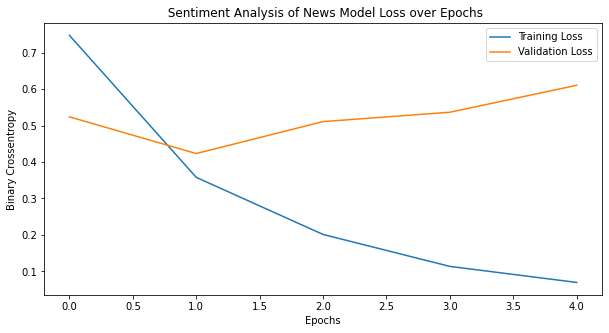

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title(' Sentiment Analysis of News Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

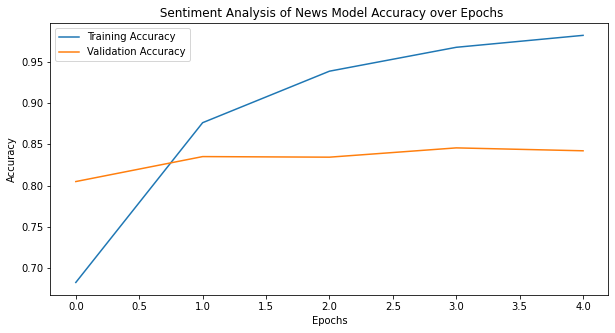

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.balanced_accuracy)
plt.plot(metrics_df.index, metrics_df.val_balanced_accuracy)
plt.title(' Sentiment Analysis of News Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()


In [ ]:
model.save("model.h5")

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

45/45 [==============================] - 7s 163ms/step


array([2.7857767e-04, 9.9908602e-01, 6.3543022e-04], dtype=float32)

In [ ]:
y_predicted = np.argmax(predicted_raw,axis=1)
y_predicted[0]

1

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(data_test.sentiment,y_predicted))

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       177
         1.0       0.86      0.91      0.88       847
         2.0       0.83      0.72      0.77       400

    accuracy                           0.85      1424
   macro avg       0.83      0.82      0.83      1424
weighted avg       0.85      0.85      0.84      1424



In [ ]:
texts = input(str('Enter the text: '))
x_val = tokenizer(text=texts,add_special_tokens=True,max_length=60,truncation=True,padding='max_length',return_tensors='tf',return_token_type_ids=True,return_attention_mask=True,verbose=True)
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
pred_val = np.argmax(validation,axis = 1)
if pred_val==0:
  print("Negative")
elif pred_val==1:
  print("Neutral")
else:
  print("Positive")

Enter the text: Hello
1/1 [==============================] - 0s 169ms/step
Neutral


In [ ]:
import tensorflow as tf
my_model = tf.keras.models.save_model('model','.content/my_model.h5')

AttributeError: ignored

In [ ]:
import transformers
weight = transformers.TFBertModel.from_pretrained('/content/sentiment_weights.h5')
# Load a pretrained BERT model
model = transformers.TFBertModel.from_pretrained('/content/model.h5')

OSError: ignored

In [ ]:
new_model = tf.saved_model.load('model.h5')

OSError: ignored

In [ ]:
new_model = tf.keras.models.load_model('/content/my_model')

ValueError: ignored

In [ ]:
new_model.summary()